In [1]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.dirname(current_dir)

# Append the parent directory to sys.path
sys.path.append(parent_dir)

# Verify that the parent directory was added
print(sys.path[-1])

/home/yuki/quant_project/EURUSD-LSTM-prediction


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from data_processing import *
import matplotlib.pyplot as plt
import seaborn

return_test_day = [1,3,5]
prediction_parameters_dic = {"Forecast period":1, "time_rolling_window":22}


df_tech = pd.read_csv("../Data/USDJPY_OHLC.csv")
# df_tech["Dates"]=pd.to_datetime(df_tech['Dates'])
# df_tech = df_tech[df_tech["Dates"] > pd.to_datetime("2002-01-01") ] 

df_tech["Last_Return"] =((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_tech["Predict_Return"] = ((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_tech.dropna(inplace=True)
df_tech

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,Last_Return,Predict_Return
1,1980/1/3,238.35,238.35,238.35,238.35,-0.000419,-0.014894
2,1980/1/4,234.80,234.80,234.80,234.80,-0.014894,-0.013842
3,1980/1/7,231.55,231.55,231.55,231.55,-0.013842,0.013820
4,1980/1/8,234.75,234.75,234.75,234.75,0.013820,0.000852
5,1980/1/9,234.95,234.95,234.95,234.95,0.000852,0.003618
...,...,...,...,...,...,...,...
11618,2024/7/15,157.84,158.42,157.19,158.06,0.001457,0.001835
11619,2024/7/16,158.06,158.86,158.00,158.35,0.001835,-0.013578
11620,2024/7/17,158.34,158.61,156.07,156.20,-0.013578,0.007490
11621,2024/7/18,156.20,157.40,155.38,157.37,0.007490,0.000699


In [3]:
import sys
import os
# sys.path.append("./factors")
# import tech_indicators
from factors import tech_indicators

USDJPY_close = df_tech['PX_LAST'].to_numpy()
USDJPY_typical = ((df_tech['PX_HIGH']+df_tech['PX_LOW']+df_tech['PX_LAST'])/3).to_numpy()

tech_dict =( {"SMA":[[10]],"EMA":[[5,100]],"RSI":[[10],[30],[100]],"MACD":[[26,12],[12,5],[42,18]],"ROC":[[5]],"Bollinger_Bands_lower":[[12],[100]],
             "Bollinger_Bands_upper":[[12],[100]],
              "CCI":[[10],[100]]} )

for key,value in tech_dict.items():
    
    for value in value:
        df_column_name = key
        for para in value:
            df_column_name += ("_"+str(para))
        
        if key[:3] == "CCI":
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(USDJPY_typical,getattr(tech_indicators,key),*value)
            
        else:
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(USDJPY_close,getattr(tech_indicators,key),*value)
        
df_tech.dropna(inplace=True,ignore_index=True)


df_tech

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,Last_Return,Predict_Return,SMA_10,EMA_5_100,RSI_10,...,MACD_26_12,MACD_12_5,MACD_42_18,ROC_5,Bollinger_Bands_lower_12,Bollinger_Bands_lower_100,Bollinger_Bands_upper_12,Bollinger_Bands_upper_100,CCI_10,CCI_100
0,1980/5/21,224.40,224.40,224.40,224.40,-0.010364,-0.001560,228.470,-110004.700000,34.805195,...,-6.612349,-1.674802,-7.855266,-0.014925,223.781396,227.572993,234.276937,258.684007,-134.057529,-194.397015
1,1980/5/22,224.05,224.05,224.05,224.05,-0.001560,-0.012497,227.515,28289.229630,37.640449,...,-6.413818,-1.678434,-8.200525,-0.024172,222.764120,226.999937,234.002546,258.971063,-137.909899,-192.097577
2,1980/5/23,221.25,221.25,221.25,221.25,-0.012497,0.000000,226.460,126773.537037,42.948718,...,-6.319445,-2.607804,-8.459722,-0.033843,221.064940,226.367223,233.935060,259.332777,-179.407096,-214.528123
3,1980/5/26,221.25,221.25,221.25,221.25,0.000000,-0.009266,225.905,141133.632716,35.036496,...,-6.608238,-2.828137,-8.359897,-0.024256,220.323414,225.859303,232.618253,259.634697,-122.467449,-210.151438
4,1980/5/27,219.20,219.20,219.20,219.20,-0.009266,0.019617,225.050,10505.295062,31.578947,...,-7.353031,-2.722208,-8.593441,-0.023173,218.976009,225.135327,231.865658,260.047673,-129.138788,-223.374622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11518,2024/7/15,157.84,158.42,157.19,158.06,0.001457,0.001835,160.374,-32237.003333,19.137466,...,0.567377,-0.883627,1.267316,-0.020269,157.793239,147.367981,163.220094,162.486819,-145.549381,65.014890
11519,2024/7/16,158.06,158.86,158.00,158.35,0.001835,-0.013578,160.065,167915.171481,19.571046,...,0.458689,-0.918208,1.150419,-0.020657,157.348151,147.468675,163.243516,162.542925,-86.477867,74.680207
11520,2024/7/17,158.34,158.61,156.07,156.20,-0.013578,0.007490,159.516,61781.160988,15.153088,...,0.187489,-1.637167,0.868412,-0.016620,156.243572,147.570365,163.471428,162.551435,-120.766326,42.722246
11521,2024/7/18,156.20,157.40,155.38,157.37,0.007490,0.000699,159.125,-12037.342840,17.952218,...,0.013562,-1.599684,0.630174,-0.002915,155.799715,147.700627,163.236952,162.568973,-106.276413,36.481058


In [4]:
split_point = int(df_tech.shape[0]*0.9)
df_train = df_tech.iloc[:split_point,:]
df_test = df_tech.iloc[split_point:,:]

x_train = df_train.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_train = df_train.loc[:, "Predict_Return"].to_numpy()

x_test = df_test.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_test = df_test.loc[:, "Predict_Return"].to_numpy()

scale_x = StandardScaler()

x_train_norm = scale_x.fit_transform(x_train)
x_test_norm = scale_x.transform(x_test)

time_delta = prediction_parameters_dic["time_rolling_window"]
x_train_norm_rolling,x_test_norm_rolling = rolling_split(x_train_norm,time_delta),rolling_split(x_test_norm,time_delta)
y_train_rolling,y_test_rolling = y_train[time_delta-1:,...],y_test[time_delta-1:,...]

threshold = threshold_search(y_train,1e-6)

print(threshold)

0.002039


In [5]:
y_train_rolling_label , y_test_rolling_label  = labelize(y_train_rolling,threshold),labelize(y_test_rolling,threshold) 

train_set = torch.utils.data.TensorDataset(torch.from_numpy(x_train_norm_rolling),torch.from_numpy(y_train_rolling_label).to(torch.int64))

test_set = torch.utils.data.TensorDataset(torch.from_numpy(x_test_norm_rolling),torch.from_numpy(y_test_rolling_label).to(torch.int64))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)

In [6]:
import time_net

hyperparas = {'input_dim':x_train.shape[-1],'hidden_dim':32,'hidden_nums':2,'output_dim':3,'block_layer_nums':2, 'LSTM_layer_nums':1
        , 'dropout_rate':0.5}

net_test = time_net.LSTM_Net(hyperparas=hyperparas)

device = torch.device('cuda')

net_test.to(device=device,dtype=torch.float64)
loss = nn.CrossEntropyLoss()


def train_epoch(loss_function, optimizer, model, loader,train_data,test_data):
  loss_train = 0
  loss_test = 0
  
  for(i, (x, y)) in enumerate(loader):
    # Clear the gradients
    optimizer.zero_grad()
    
    x=x.to(device=device)
    y=y.to(device=device)
    # Run a forward pass
    outputs = model.forward(x)
    # Compute the batch loss
    loss = loss_function(outputs,y)
    # Calculate the gradients
    loss.backward()
    # Update the parameteres
    optimizer.step()

    
  with torch.no_grad():
    train_outputs = model.forward(train_data[:][0].to(device=device))
    train_loss = loss_function(train_outputs,train_data[:][1].to(device=device))
    loss_train = train_loss.detach().cpu()
    print(f"train loss is {train_loss}")
    
    test_outputs = model.forward(test_data[:][0].to(device=device))
    test_loss = loss_function(test_outputs,test_data[:][1].to(device=device))
    loss_test = test_loss.detach().cpu()
    
    print(f"test loss is {test_loss}")
        
  return [loss_train, loss_test]   



def train_model(loss_function, optimizer, model, loader,train_data,test_data,epochs=25):
  loss_ls = []
  
  for i in range(epochs):
    print(f"-----------------------Epoch: {i+1}----------------------------------")

    loss_ls.append(train_epoch(loss_function, optimizer, model, loader,train_data,test_data))
    
  return loss_ls

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [7]:
optim_Adam = torch.optim.Adam(net_test.parameters(),lr = 0.0001)
epochs = 50
loss_ls = train_model(loss_function=loss,optimizer=optim_Adam,model=net_test,loader=train_loader,train_data=train_set,
                      test_data=test_set,epochs=epochs)

-----------------------Epoch: 1----------------------------------
train loss is 1.1812896127645636
test loss is 1.1810721784042804
-----------------------Epoch: 2----------------------------------
train loss is 1.1593101617027382
test loss is 1.1487153701690598
-----------------------Epoch: 3----------------------------------
train loss is 1.145560656103007
test loss is 1.145413561470953
-----------------------Epoch: 4----------------------------------
train loss is 1.1257107632942644
test loss is 1.1326042563655125
-----------------------Epoch: 5----------------------------------
train loss is 1.1209783166166525
test loss is 1.11862219339522
-----------------------Epoch: 6----------------------------------
train loss is 1.1215783314667926
test loss is 1.116377536074268
-----------------------Epoch: 7----------------------------------
train loss is 1.1127457860841068
test loss is 1.1117427658013894
-----------------------Epoch: 8----------------------------------
train loss is 1.111833

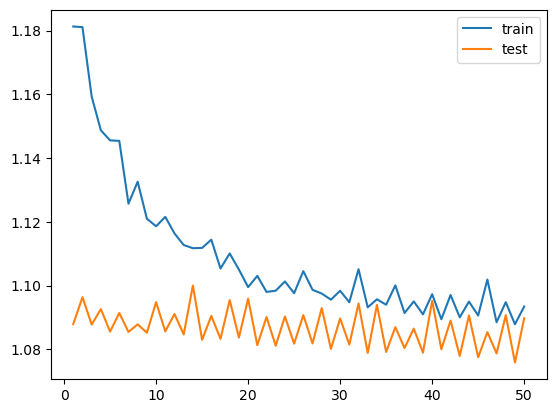

In [8]:
loss_array = np.array(loss_ls).reshape((2,epochs))

plt.plot(range(1,len(loss_array[0])+1),loss_array[0],label = "train")
plt.plot(range(1,len(loss_array[1])+1),loss_array[1],label= "test")
plt.legend()
plt.show()

In [9]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

net_test.to(device=torch.device("cpu"))
net_test.eval()

predict_probability = torch.max(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)[0]

predict_results = torch.argmax(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)
real_results = test_set[:][1]

accuracy_score(real_results,predict_results)

0.3833922261484099

In [10]:
act_predict_bool = (predict_results != 1) & (predict_probability > 0.4)

act_predict_results = predict_results[act_predict_bool]
act_real_results = real_results[act_predict_bool]

accuracy_score(act_predict_results,act_real_results)

0.40625

In [11]:
act_predict_results.shape

torch.Size([128])

In [13]:
# saved_path = "../trained_model/USDJPY_Tec_LSTM.pth"

# torch.save(net_test.state_dict(),saved_path )